*******
# Introduction

The goal of my final project is to accurately predict county-level unemployment rates in the United States using historical data. The unemployment rate measures the number of unemployed workers as a percentage of the labor force and is typically used to evaluate the health of the labor market. This statistic is especially important during recessions to determine the economic condition of a given area. This problem is important because high levels of unemployment can seriously damage a nation's economic growth and financial development. Being able to predict the unemployment rate will allow us to understand the factors that are associated with high and low levels of unemployment. This allows us to more efficiently and effectively implement policies to reduce the unemployment rate. 

*******
# Data Wrangling and Cleaning

The data set used for this project came from the 2019 American Community Survey (5-year estimates) and was retrieved from [Social Explorer](https://www.socialexplorer.com/explore-maps).

[Link to the downloaded report](https://www.socialexplorer.com/tables/ACS2019_5yr/R12785313)

The data used to classify counties as metro or nonmetro came from the [US Department of Agriculture Economic Research Reserve](https://www.ers.usda.gov/data-products/rural-urban-continuum-codes.aspx). The data set used was the 2013 Rural-Urban Continuum Codes.

In [1]:
# import tools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from scipy.stats import binned_statistic

# change directory
os.chdir('C:/Users/hubst/ECON_490/Final Project')

# increase size of figures
sns.set(rc = {'axes.titlesize': 20,
              'axes.labelsize': 15,
              'xtick.labelsize': 10,
              'ytick.labelsize': 10,
              'figure.figsize': (10, 5)})

In [2]:
# load in data
data = pd.read_csv('final_project.csv')

# load in metro classification table
codes = pd.read_excel('ruralurbancodes2013.xlsx', engine = 'openpyxl')

In [3]:
# print head of codes
codes.head()

,FIPS,State,County_Name,Population_2010,RUCC_2013,Description
0,1001.0,AL,Autauga County,54571.0,2.0,"Metro - Counties in metro areas of 250,000 to ..."
1,1003.0,AL,Baldwin County,182265.0,3.0,Metro - Counties in metro areas of fewer than ...
2,1005.0,AL,Barbour County,27457.0,6.0,"Nonmetro - Urban population of 2,500 to 19,999..."
3,1007.0,AL,Bibb County,22915.0,1.0,Metro - Counties in metro areas of 1 million p...
4,1009.0,AL,Blount County,57322.0,1.0,Metro - Counties in metro areas of 1 million p...


In [4]:
# setting metro status as a categorical feature with metro being 1 and nonmetro being 0
codes['Metro Status'] = (codes['RUCC_2013'] <= 3)*1

In [5]:
# trimming codes table by selecting only variables that are needed
codes = codes[['FIPS', 'Metro Status']]

In [6]:
# dropping nan values from codes
codes.dropna(inplace = True)

# changing FIPS to int to remove the decimal place
codes['FIPS'] = codes['FIPS'].astype(int)

In [7]:
# print head of data to see what I'm working with
data.head()

,FIPS,Geographic Identifier,Area Name,Qualifying Name,State Postal Abbreviation,Summary Level,Geographic Component,File identification,Logical Record Number,US,...,Average Commute to Work (In Min),Total Population:.2,Total Population: Native Born,Total Population: Foreign Born,Total Population: Foreign Born: Naturalized Citizen,Total Population: Foreign Born: Not a Citizen,% Total Population: Native Born,% Total Population: Foreign Born,% Total Population: Foreign Born: Naturalized Citizen,% Total Population: Foreign Born: Not a Citizen
0,Geo_FIPS,Geo_GEOID,Geo_NAME,Geo_QName,Geo_STUSAB,Geo_SUMLEV,Geo_GEOCOMP,Geo_FILEID,Geo_LOGRECNO,Geo_US,...,SE_A09003_001,SE_A06001_001,SE_A06001_002,SE_A06001_003,SE_A06001_004,SE_A06001_005,PCT_SE_A06001_002,PCT_SE_A06001_003,PCT_SE_A06001_004,PCT_SE_A06001_005
1,01001,05000US01001,Autauga County,"Autauga County, Alabama",al,050,00,ACSSF,0000013,NaN,...,24,55380,54081,1299,750,549,97.65,2.35,1.35,0.99
2,01003,05000US01003,Baldwin County,"Baldwin County, Alabama",al,050,00,ACSSF,0000014,NaN,...,27,212830,204906,7924,3650,4274,96.28,3.72,1.71,2.01
3,01005,05000US01005,Barbour County,"Barbour County, Alabama",al,050,00,ACSSF,0000015,NaN,...,22,25361,24672,689,335,354,97.28,2.72,1.32,1.4
4,01007,05000US01007,Bibb County,"Bibb County, Alabama",al,050,00,ACSSF,0000016,NaN,...,30,22493,22153,340,140,200,98.49,1.51,0.62,0.89


In [8]:
# drop first row
data = data.drop(index = 0)

In [9]:
# set fips column in data as int to match the data type in the codes table
data['FIPS'] = data['FIPS'].astype(int)

In [10]:
# merging data and codes via an inner join
data = data.set_index('FIPS').join(codes.set_index('FIPS'), how = 'inner')

In [11]:
# dropping nan values within these features so they don't get dropped
data.dropna(subset = ['Average Gross Rent for Renter-Occupied Housing Units'], inplace = True)
data.dropna(subset = ['Average Commute to Work (In Min)'], inplace = True)

# drop all columns with nan values
data = data.dropna(axis = 'columns')

# rename geographic identifier for county
data.rename(columns = {'Qualifying Name': 'County'}, inplace = True)

# append county to the index
data.set_index(['County'], append = True, inplace = True)

# drop unnecessary geographic columns
data = data.drop(columns = ['Geographic Identifier', 'Area Name', 'State Postal Abbreviation', 
                            'Summary Level','Geographic Component', 'File identification', 
                            'Logical Record Number', 'State (FIPS Code)', 'County of current residence'])

# drop duplicated columns
data = data.drop(columns = ['Total Population:', 'Total Population:.1', 'Total Population:.2', 
                            'Total Employed Civilian Population 16 Years and Over'])

In [12]:
# changing all data values to numeric
data = data.apply(pd.to_numeric)

In [13]:
# creating features

# percentage of population that is living in poverty
data['Poverty Level'] = (data['Population Under 18 Years of Age for Whom Poverty Status Is Determined: Living in Poverty'] + 
                         data['Population Age 18 to 64 for Whom Poverty Status  Is Determined: Living in Poverty'] + 
                         data['Population Age 65 and Over for Whom Poverty  Status Is Determined: Living in Poverty'])*100/data['Total Population']

# percentage of adults with at least a bachelor's degree
data["Bachelor's or more"] = (data["Population 25 Years and Over: Bachelor's Degree"] + 
                              data["Population 25 Years and Over: Master's Degree"] + 
                              data["Population 25 Years and Over: Professional School Degree"] + 
                              data["Population 25 Years and Over: Doctorate Degree"])*100/data['Population 25 Years and Over:']

In [14]:
# renaming features
data.rename(columns = {'Median Household Income (In 2019 Inflation Adjusted Dollars)': 'Median Household Income',
                       'Average Gross Rent for Renter-Occupied Housing Units': 'Average Rent',
                       'Median Age:': 'Median Age',
                       'Average Commute to Work (In Min)': 'Average Commute Time', 
                       '% Population 16 Years and Over: in Labor Force: Civilian: Unemployed': 'Unemployment Rate',
                       '% Total Population: Female': 'Female',
                       '% Total Population: Foreign Born': 'Immigrant', 
                       '% Total Population: Black or African American Alone': 'African American',
                       '% Total Population: Hispanic or Latino': 'Hispanic',
                       '% Female Population 16 Years and Over: in Labor Force': 'Female Labor Force Participation Rate',
                       '% Employed Civilian Population 16 Years and Over: Manufacturing': 'Manufacturing',
                       '% Employed Civilian Population 16 Years and Over: Agriculture, Forestry, Fishing and Hunting, and Mining': 'Agriculture and Mining'}, inplace = True)

In [15]:
# reordering features and dropping columns that are unnecessary
data = data[['Unemployment Rate', 'Female Labor Force Participation Rate', 'Female', 'African American', 'Hispanic', 
             "Bachelor's or more", 'Manufacturing', 'Agriculture and Mining', 'Immigrant', 'Poverty Level', 'Median Age', 
             'Average Household Size', 'Median Household Income', 'Average Rent', 'Average Commute Time', 'Metro Status']]

In [16]:
# check out head of data to make sure everything looks correct
data.head()

,,Unemployment Rate,Female Labor Force Participation Rate,Female,African American,Hispanic,Bachelor's or more,Manufacturing,Agriculture and Mining,Immigrant,Poverty Level,Median Age,Average Household Size,Median Household Income,Average Rent,Average Commute Time,Metro Status
FIPS,County,,,,,,,,,,,,,,,,
1001,"Autauga County, Alabama",2.13,51.51,51.37,19.03,2.83,26.571574,12.95,0.87,2.35,15.059588,38.2,2.56,58731,980.419948,24,1
1003,"Baldwin County, Alabama",2.45,52.82,51.37,9.26,4.56,31.862460,9.25,1.21,3.72,10.197810,43.0,2.59,58320,941.294799,27,1
1005,"Barbour County, Alabama",4.11,44.66,47.08,47.58,4.36,11.578713,23.05,5.72,2.72,27.108553,40.4,2.41,32525,546.168582,22,0
1007,"Bibb County, Alabama",3.56,49.60,45.98,22.29,2.57,10.378525,16.90,3.86,1.51,16.627395,40.9,2.99,47542,560.294952,30,1
1009,"Blount County, Alabama",1.66,44.18,50.60,1.61,9.26,13.093413,17.16,2.08,4.54,13.416896,40.7,2.74,49358,555.809222,34,1


In [17]:
# check out shape of the data
data.shape

(3216, 16)

In [18]:
# check out data type to make sure everything looks correct
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 3216 entries, (1001, 'Autauga County, Alabama') to (72153, 'Yauco Municipio, Puerto Rico')
Data columns (total 16 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   Unemployment Rate                      3216 non-null   float64
 1   Female Labor Force Participation Rate  3216 non-null   float64
 2   Female                                 3216 non-null   float64
 3   African American                       3216 non-null   float64
 4   Hispanic                               3216 non-null   float64
 5   Bachelor's or more                     3216 non-null   float64
 6   Manufacturing                          3216 non-null   float64
 7   Agriculture and Mining                 3216 non-null   float64
 8   Immigrant                              3216 non-null   float64
 9   Poverty Level                          3216 non-null   float64
 10  Media

In [19]:
# check out descriptive statistics of the data
data.describe()

,Unemployment Rate,Female Labor Force Participation Rate,Female,African American,Hispanic,Bachelor's or more,Manufacturing,Agriculture and Mining,Immigrant,Poverty Level,Median Age,Average Household Size,Median Household Income,Average Rent,Average Commute Time,Metro Status
count,3216.000000,3216.000000,3216.000000,3216.000000,3216.000000,3216.000000,3216.000000,3216.000000,3216.000000,3216.000000,3216.000000,3216.000000,3216.000000,3216.000000,3216.000000,3216.000000
mean,3.078759,53.656878,49.964471,9.159356,11.571688,21.985656,12.249238,6.427453,4.686807,15.302330,41.437158,2.521210,52652.674440,700.829105,23.964552,0.384017
std,1.554574,7.565923,2.346874,14.622991,19.385061,9.491006,7.092657,7.188999,5.697437,7.838040,5.337611,0.275519,14981.141925,267.697479,5.900364,0.486438
min,0.000000,18.110000,27.280000,0.000000,0.000000,1.047120,0.000000,0.000000,0.000000,2.355808,22.300000,1.410000,12441.000000,84.057971,5.000000,0.000000
25%,2.190000,48.880000,49.430000,0.727500,2.260000,15.424850,6.847500,1.650000,1.330000,10.402349,38.300000,2.350000,43539.250000,534.910945,20.000000,0.000000
50%,2.880000,54.100000,50.390000,2.395000,4.380000,19.629423,11.330000,3.915000,2.675000,13.808197,41.300000,2.480000,51493.000000,648.983460,24.000000,0.000000
75%,3.680000,59.022500,51.170000,10.282500,10.392500,25.958667,16.560000,8.272500,5.590000,18.142045,44.500000,2.640000,59519.250000,813.529932,28.000000,1.000000
max,15.560000,77.580000,57.190000,87.230000,99.980000,77.557411,47.530000,59.640000,53.720000,64.493827,67.400000,4.140000,142299.000000,2301.892381,53.000000,1.000000


In [20]:
# creating pickle
data.to_pickle('final_project.pkl')

*******
# Label Figure

In [21]:
# transforming data with log(y + 1)
data['log Unemployment Rate'] = np.log10(data['Unemployment Rate'] + 1)

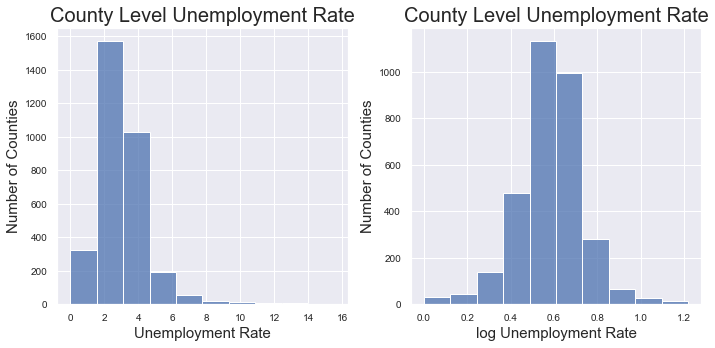

In [22]:
plt.subplot(1, 2, 1)
sns.histplot(data = data, x = 'Unemployment Rate', bins = 10)
plt.title('County Level Unemployment Rate')
plt.ylabel('Number of Counties')
plt.xlabel('Unemployment Rate')

plt.subplot(1, 2, 2)
sns.histplot(data = data, x = 'log Unemployment Rate', bins = 10)
plt.title('County Level Unemployment Rate')
plt.ylabel('Number of Counties')
plt.xlabel('log Unemployment Rate')

plt.tight_layout()

A log transformation is appropriate for the label. However, because some of the values of the label are equal to 0, I used `log(y + 1)` to transform the data.

In [23]:
data.drop(columns = 'Unemployment Rate', inplace = True)

*******
# Feature Transformations

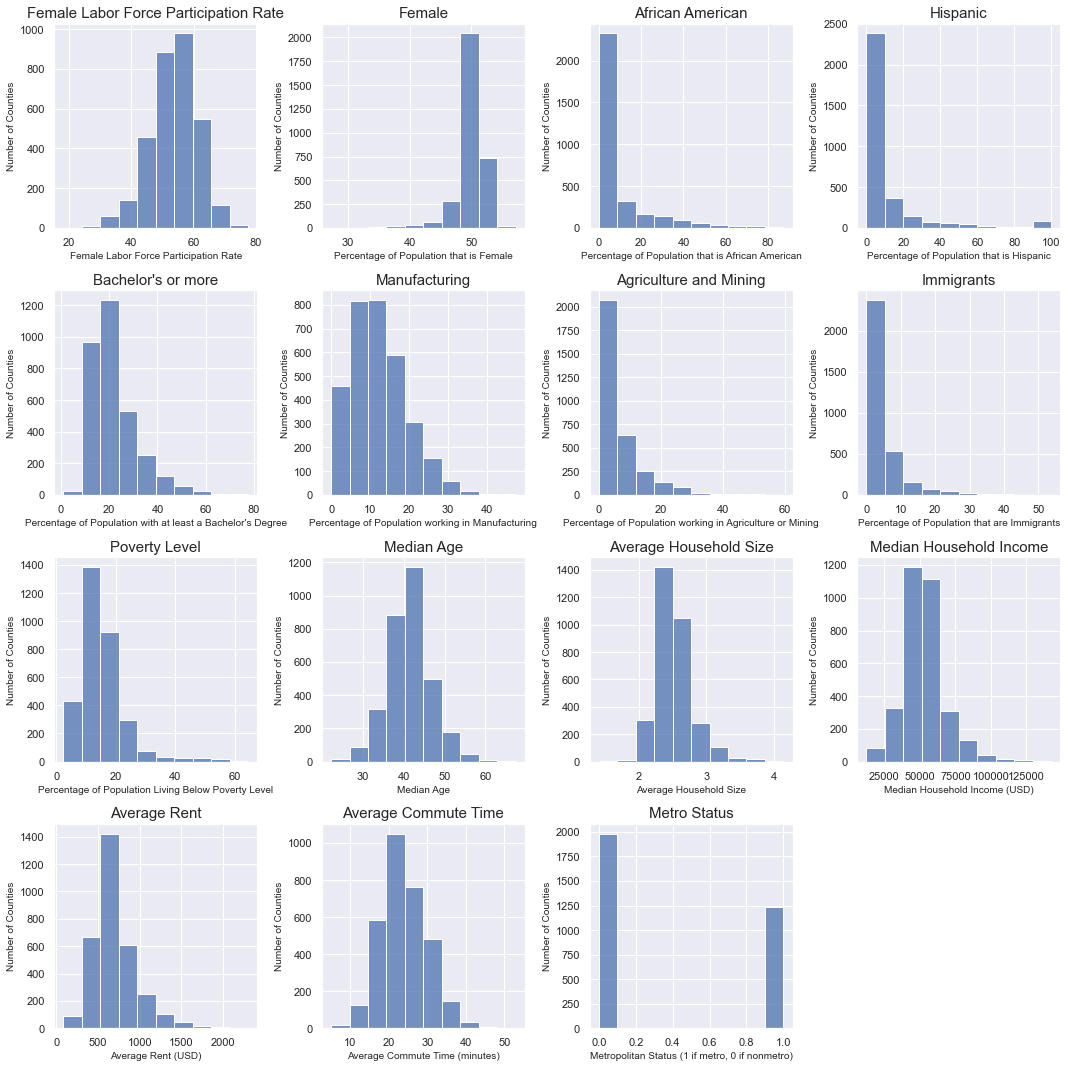

In [24]:
sns.set(rc = {'axes.titlesize': 15,
              'axes.labelsize': 10,
              'figure.figsize': (15, 15)})

plt.subplot(4, 4, 1)
sns.histplot(data = data, x = 'Female Labor Force Participation Rate', bins = 10)
plt.title('Female Labor Force Participation Rate')
plt.ylabel('Number of Counties')
plt.xlabel('Female Labor Force Participation Rate')

plt.subplot(4, 4, 2)
sns.histplot(data = data, x = 'Female', bins = 10)
plt.title('Female')
plt.ylabel('Number of Counties')
plt.xlabel('Percentage of Population that is Female')

plt.subplot(4, 4, 3)
sns.histplot(data = data, x = 'African American', bins = 10)
plt.title('African American')
plt.ylabel('Number of Counties')
plt.xlabel('Percentage of Population that is African American')

plt.subplot(4, 4, 4)
sns.histplot(data = data, x = 'Hispanic', bins = 10)
plt.title('Hispanic')
plt.ylabel('Number of Counties')
plt.xlabel('Percentage of Population that is Hispanic')

plt.subplot(4, 4, 5)
sns.histplot(data = data, x = "Bachelor's or more", bins = 10)
plt.title("Bachelor's or more")
plt.ylabel('Number of Counties')
plt.xlabel("Percentage of Population with at least a Bachelor's Degree")

plt.subplot(4, 4, 6)
sns.histplot(data = data, x = 'Manufacturing', bins = 10)
plt.title('Manufacturing')
plt.ylabel('Number of Counties')
plt.xlabel('Percentage of Population working in Manufacturing')

plt.subplot(4, 4, 7)
sns.histplot(data = data, x = 'Agriculture and Mining', bins = 10)
plt.title('Agriculture and Mining')
plt.ylabel('Number of Counties')
plt.xlabel('Percentage of Population working in Agriculture or Mining')

plt.subplot(4, 4, 8)
sns.histplot(data = data, x = 'Immigrant', bins = 10)
plt.title('Immigrants')
plt.ylabel('Number of Counties')
plt.xlabel('Percentage of Population that are Immigrants')

plt.subplot(4, 4, 9)
sns.histplot(data = data, x = 'Poverty Level', bins = 10)
plt.title('Poverty Level')
plt.ylabel('Number of Counties')
plt.xlabel('Percentage of Population Living Below Poverty Level')

plt.subplot(4, 4, 10)
sns.histplot(data = data, x = 'Median Age', bins = 10)
plt.title('Median Age')
plt.ylabel('Number of Counties')
plt.xlabel('Median Age')

plt.subplot(4, 4, 11)
sns.histplot(data = data, x = 'Average Household Size', bins = 10)
plt.title('Average Household Size')
plt.ylabel('Number of Counties')
plt.xlabel('Average Household Size')

plt.subplot(4, 4, 12)
sns.histplot(data = data, x = 'Median Household Income', bins = 10)
plt.title('Median Household Income')
plt.ylabel('Number of Counties')
plt.xlabel('Median Household Income (USD)')

plt.subplot(4, 4, 13)
sns.histplot(data = data, x = 'Average Rent', bins = 10)
plt.title('Average Rent')
plt.ylabel('Number of Counties')
plt.xlabel('Average Rent (USD)')

plt.subplot(4, 4, 14)
sns.histplot(data = data, x = 'Average Commute Time', bins = 10)
plt.title('Average Commute Time')
plt.ylabel('Number of Counties')
plt.xlabel('Average Commute Time (minutes)')

plt.subplot(4, 4, 15)
sns.histplot(data = data, x = 'Metro Status', bins = 10)
plt.title('Metro Status')
plt.ylabel('Number of Counties')
plt.xlabel('Metropolitan Status (1 if metro, 0 if nonmetro)')

plt.tight_layout()

The features that need transformations are `Female`, `African American`, `Hispanic`, `Bachelor's or more`, `Manufacturing`, `Agriculture and Mining`, `Immigrants` and `Poverty Level`.  

In [25]:
data['cube Female'] = np.power(data['Female'], 3)
data = data.drop(columns = 'Female')

data['log African American'] = np.log10(data['African American'] + 1)
data = data.drop(columns = 'African American')

data['log Hispanic'] = np.log10(data['Hispanic'] + 1)
data = data.drop(columns = 'Hispanic')

data["log Bachelor's or more"] = np.log10(data["Bachelor's or more"] + 1)
data = data.drop(columns = "Bachelor's or more")

data['log Agriculture and Mining'] = np.log10(data['Agriculture and Mining'] + 1)
data = data.drop(columns = 'Agriculture and Mining')

data['log Poverty Level'] = np.log10(data['Poverty Level'] + 1)
data = data.drop(columns = 'Poverty Level')

data['log Immigrant'] = np.log10(data['Immigrant'] + 1)
data = data.drop(columns = 'Immigrant')

data['log Manufacturing'] = np.log10(data['Manufacturing'] + 1)
data = data.drop(columns = 'Manufacturing')

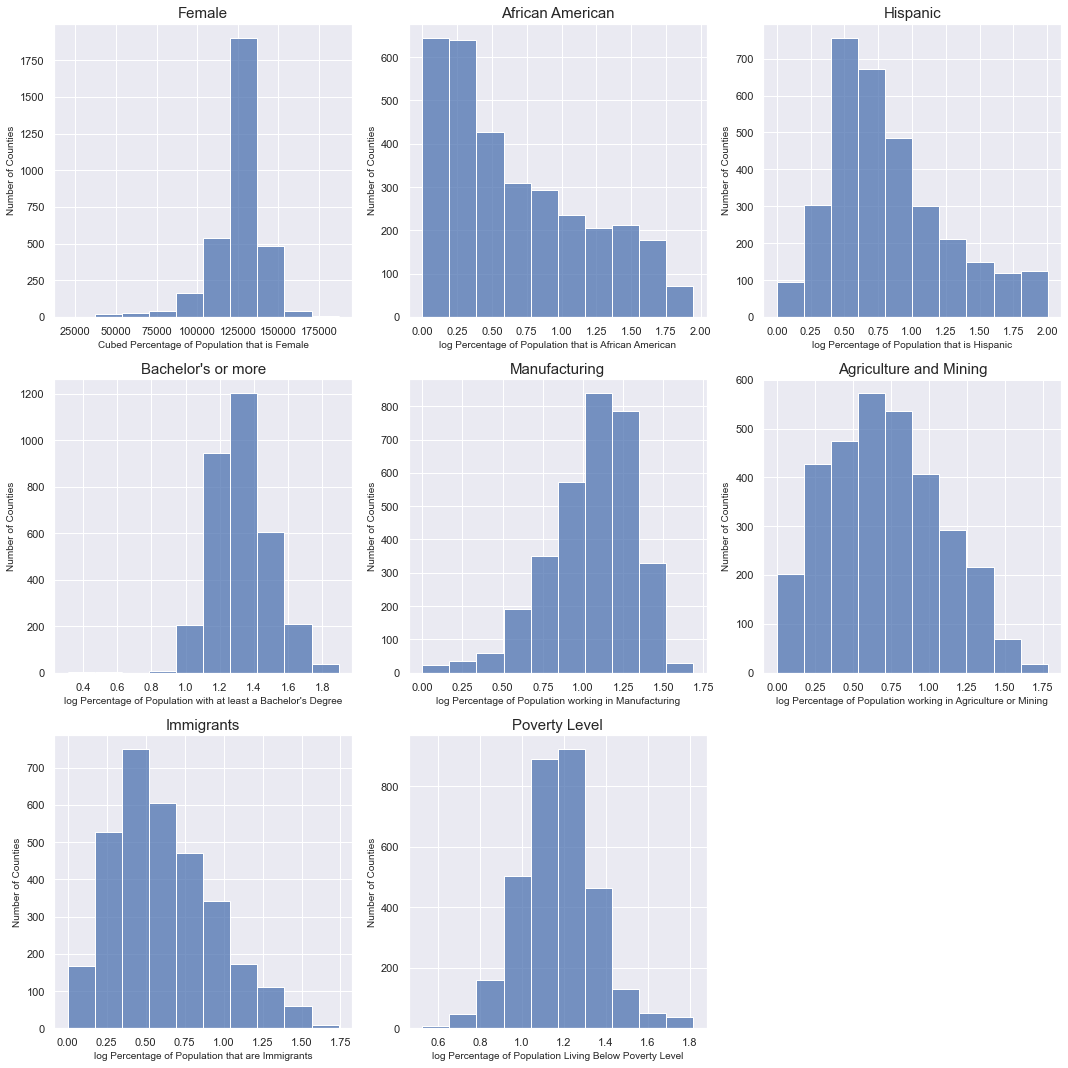

In [26]:
# checking the transformed features
plt.subplot(3, 3, 1)
sns.histplot(data = data, x = 'cube Female', bins = 10)
plt.title('Female')
plt.ylabel('Number of Counties')
plt.xlabel('Cubed Percentage of Population that is Female')

plt.subplot(3, 3, 2)
sns.histplot(data = data, x = 'log African American', bins = 10)
plt.title('African American')
plt.ylabel('Number of Counties')
plt.xlabel('log Percentage of Population that is African American')

plt.subplot(3, 3, 3)
sns.histplot(data = data, x = 'log Hispanic', bins = 10)
plt.title('Hispanic')
plt.ylabel('Number of Counties')
plt.xlabel('log Percentage of Population that is Hispanic')

plt.subplot(3, 3, 4)
sns.histplot(data = data, x = "log Bachelor's or more", bins = 10)
plt.title("Bachelor's or more")
plt.ylabel('Number of Counties')
plt.xlabel("log Percentage of Population with at least a Bachelor's Degree")

plt.subplot(3, 3, 5)
sns.histplot(data = data, x = 'log Manufacturing', bins = 10)
plt.title('Manufacturing')
plt.ylabel('Number of Counties')
plt.xlabel('log Percentage of Population working in Manufacturing')

plt.subplot(3, 3, 6)
sns.histplot(data = data, x = 'log Agriculture and Mining', bins = 10)
plt.title('Agriculture and Mining')
plt.ylabel('Number of Counties')
plt.xlabel('log Percentage of Population working in Agriculture or Mining')

plt.subplot(3, 3, 7)
sns.histplot(data = data, x = 'log Immigrant', bins = 10)
plt.title('Immigrants')
plt.ylabel('Number of Counties')
plt.xlabel('log Percentage of Population that are Immigrants')

plt.subplot(3, 3, 8)
sns.histplot(data = data, x = 'log Poverty Level', bins = 10)
plt.title('Poverty Level')
plt.ylabel('Number of Counties')
plt.xlabel('log Percentage of Population Living Below Poverty Level')

plt.tight_layout()

*******
# Feature vs Label Figures

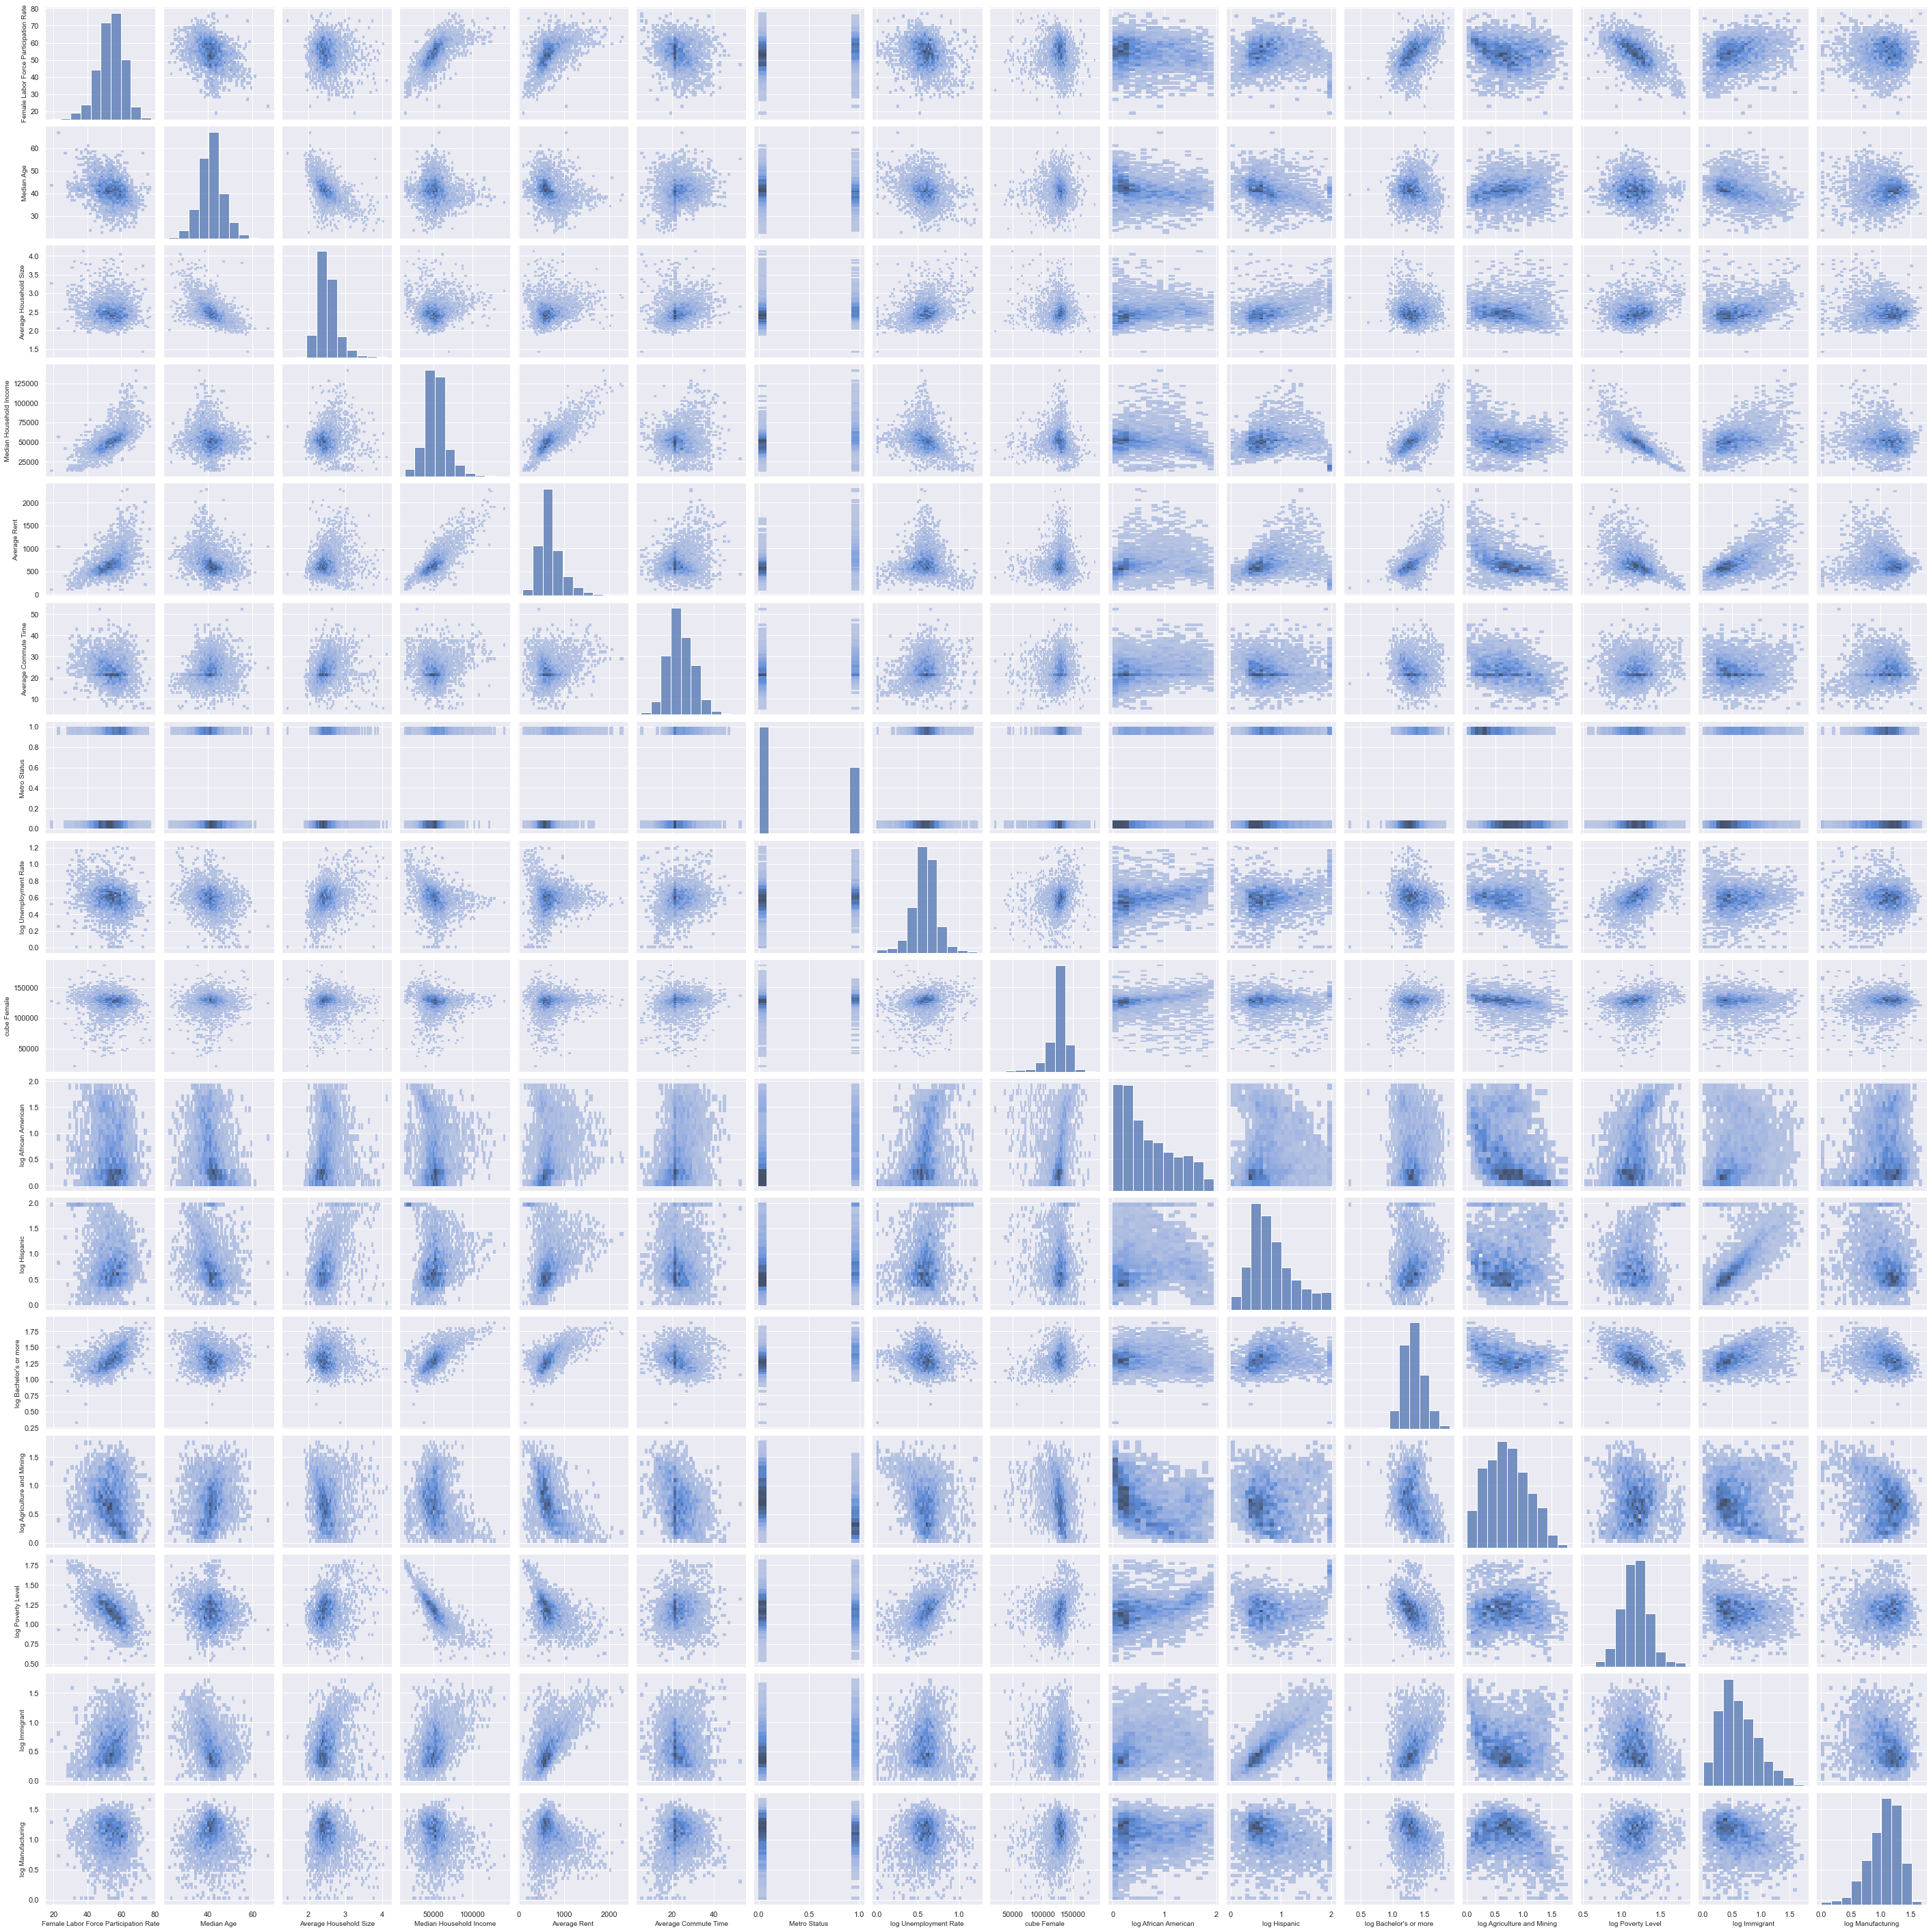

In [27]:
sns.set(rc = {'axes.labelsize': 10,})
sns.pairplot(data = data, kind = 'hist', 
             diag_kws = {'bins': 10})
plt.show()

A lot of the features seem to have a very weak or nonexistent relationship.

It looks like there is a linear relationship between `Average Rent` and `Median Household Income`.

It looks like there is a linear relationship between `Hispanic` and `Immigrant`.

It looks like there is a linear relationship between `Median Household Income` and `Poverty Level`.

It looks like there is a quadratic relationship between `Median Household Income` and `Bachelor's or more`.

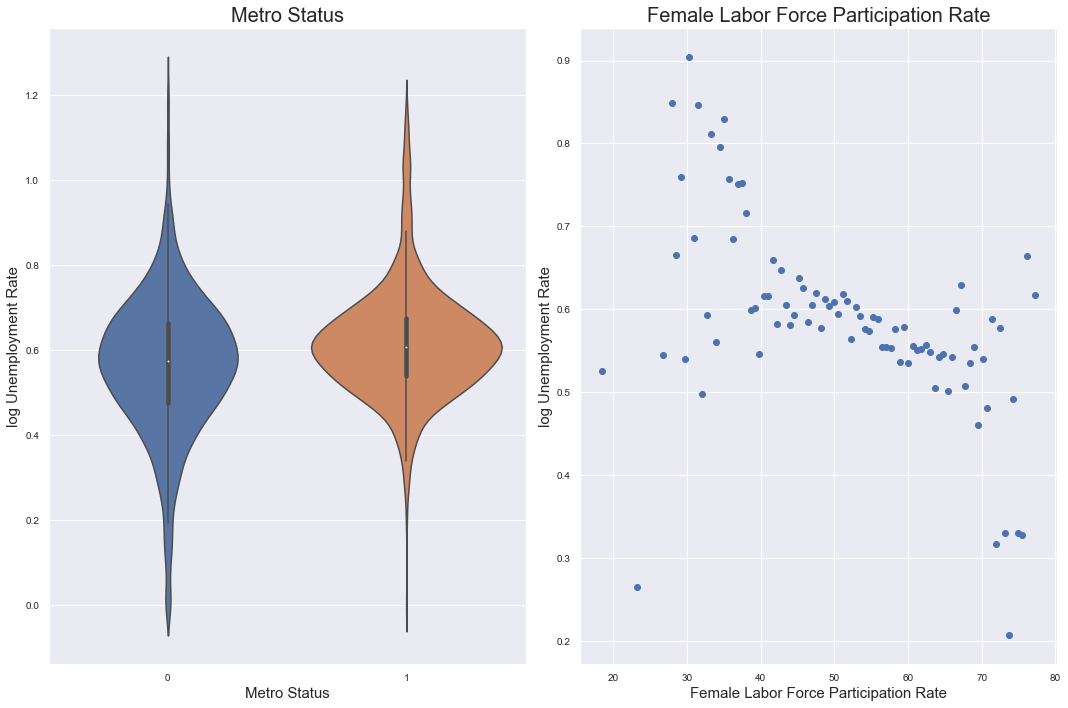

In [28]:
sns.set(rc = {'axes.titlesize': 20,
              'axes.labelsize': 15,
              'xtick.labelsize': 10,
              'ytick.labelsize': 10,
              'figure.figsize': (15, 10)})

plt.subplot(1, 2, 1)
sns.violinplot(data = data, x = 'Metro Status', y = 'log Unemployment Rate')
plt.title('Metro Status')
plt.ylabel('log Unemployment Rate')
plt.xlabel('Metro Status')

plt.subplot(1, 2, 2)
n = 100
bin_mean, bin_edge, _ = binned_statistic(data['Female Labor Force Participation Rate'], data['log Unemployment Rate'], bins = n)
x = np.average([bin_edge[:-1], bin_edge[1:]], axis = 0)
plt.scatter(x, bin_mean, label = '%d bins' % n)
plt.title('Female Labor Force Participation Rate')
plt.ylabel('log Unemployment Rate')
plt.xlabel('Female Labor Force Participation Rate')

plt.tight_layout()

It looks like `Unemployment Rate` is normally distributed for both metro and nonmetro. 

It looks like there is a weak linear relationship between the `Unemployment Rate` and `Female Labor Force Participation Rate`.

In [29]:
# updating pickle with transformed features and label
data.to_pickle('final_project.pkl')